# Seq2Seq Q&A 챗봇 구현

# 1. 데이터 취득

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')

df = df[['Q','A']]

# 2. 데이터 전처리

In [3]:
import re
import numpy as np
import pandas as pd
import sentencepiece as spm
from itertools import chain
from sklearn.model_selection import train_test_split

In [4]:
# 전처리
def clean_text(text):
    korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
    normalizer = re.compile(korean_pattern)
    return normalizer.sub('', text.strip())

df['Q_clean'] = df['Q'].map(clean_text)
df['A_clean'] = df['A'].map(clean_text)

In [5]:
# 최종 
def clean_text(text):
    korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
    normalizer = re.compile(korean_pattern)
    return normalizer.sub('', str(text).strip())

df['Q_clean'] = df['Q'].map(clean_text)
df['A_clean'] = df['A'].map(clean_text)

In [6]:
df

,Q,A,Q_clean,A_clean
0,12시 땡!,하루가 또 가네요.,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.,PPL 심하네,눈살이 찌푸려지죠.
...,...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


### 2.1 토크나이저 학습 (sentencepiece 활용)
- 접두사, 접미사 처리 (문자과 처음 끝에 붙는 bos,eos)

In [7]:
q_inputs = []  # 인코더 입력용 
a_inputs = [] #<bos> / # 디코더 입력용 
a_targets = [] #<eos> / # 디코더 타깃

In [8]:
for i in range(len(df['Q'])):
    #print(df['Q'][i])
    q = df['Q_clean'][i]
    q_input = q
    
    q_inputs.append(q_input)
    
    
#a_inputs
for i in range(len(df['A'])):
    #print(df['Q'][i])
    a = df['A_clean'][i]
    a_input = '<bos> '+ a
    
    a_inputs.append(a_input)
    
    
# a_targets
for i in range(len(df['A'])):
    #print(df['Q'][i])
    a = df['A_clean'][i]
    a_target = a + ' <eos>'
    
    a_targets.append(a_target)
    
    
    
#확인 
print(q_inputs[:5]) 
print(a_inputs[:5]) #<bos>
print(a_targets[:5]) #<eos>

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['<bos> 하루가 또 가네요.', '<bos> 위로해 드립니다.', '<bos> 여행은 언제나 좋죠.', '<bos> 여행은 언제나 좋죠.', '<bos> 눈살이 찌푸려지죠.']
['하루가 또 가네요. <eos>', '위로해 드립니다. <eos>', '여행은 언제나 좋죠. <eos>', '여행은 언제나 좋죠. <eos>', '눈살이 찌푸려지죠. <eos>']


In [9]:
#pip install --upgrade sentencepiece

### sentenceoiece 학습 

In [10]:
#sentencepiece 토큰화 

import sentencepiece as spt
from itertools import chain



# Q/A 텍스트를 한 파일로 저장
with open("chatbot_corpus.txt", "w", encoding="utf-8") as f:
    for s in q_inputs + a_inputs + a_targets:
        f.write(s.strip() + "\n")

# SentencePiece 학습
input = "chatbot_corpus.txt"
vocab_size = 9000
model_prefix = 'chatbot_model'
cmd = f'--input={input} --model_prefix={model_prefix} --vocab_size={vocab_size}'

spt.SentencePieceTrainer.Train(cmd)


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=chatbot_corpus.txt --model_prefix=chatbot_model --vocab_size=9000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: chatbot_corpus.txt
  input_format: 
  model_prefix: chatbot_model
  model_type: UNIGRAM
  vocab_size: 9000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  p

In [11]:
sp = spt.SentencePieceProcessor()
sp.Load(f'{model_prefix}.model')

True

In [12]:
# 토큰화 -> ID 시퀀스
X_enc = [sp.encode_as_ids(q) for q in q_inputs]     # 인코더 입력(Q)
Y_in  = [sp.encode_as_ids(a) for a in a_inputs]     # 디코더 입력(<bos> + A)
Y_out = [sp.encode_as_ids(a) for a in a_targets]

In [13]:
#확인
print(X_enc[:5])
print(Y_in[:5])
print(Y_out[:5])

[[5511, 543, 4621, 60], [352, 7805, 885, 2326], [398, 1749, 3672, 106, 3536, 155], [398, 1749, 3672, 106, 555, 3536, 155], [10, 0, 5753]]
[[7, 8, 6, 4, 5, 293, 13, 140, 94, 23, 3], [7, 8, 6, 4, 5, 1165, 10, 2850, 3], [7, 8, 6, 4, 5, 311, 19, 347, 68, 148, 3], [7, 8, 6, 4, 5, 311, 19, 347, 68, 148, 3], [7, 8, 6, 4, 5, 196, 1321, 20, 2503, 3266, 5816, 33, 3]]
[[293, 13, 140, 94, 23, 3, 7, 9, 6, 4, 5], [1165, 10, 2850, 3, 7, 9, 6, 4, 5], [311, 19, 347, 68, 148, 3, 7, 9, 6, 4, 5], [311, 19, 347, 68, 148, 3, 7, 9, 6, 4, 5], [196, 1321, 20, 2503, 3266, 5816, 33, 3, 7, 9, 6, 4, 5]]


### 2.2 학습용 데이터 Q_inputs, A_input, A_target 생성

- 패딩처리

- 인코더 패딩 = 'pre'
- 디코더 패딩 = 'post'

In [14]:
q_max_len = max([len(seq) for seq in X_enc])
a_in_max_len = max([len(seq) for seq in Y_in])
a_target_max_len = max([len(seq) for seq in Y_out])

print(q_max_len)
print(a_in_max_len)
print(a_target_max_len)

24
40
40


In [15]:
# 패딩 처리 


from tensorflow.keras.preprocessing.sequence import pad_sequences

q_inputs_padded = pad_sequences(X_enc, maxlen = q_max_len,padding='pre')
a_inputs_padded = pad_sequences(Y_in, maxlen = a_in_max_len, padding = 'post')
a_targets_padded = pad_sequences(Y_out, maxlen = a_target_max_len, padding = 'post')

In [16]:
# 패딩 확인 
print(q_inputs_padded.shape)  
print(a_inputs_padded.shape)   
print(a_targets_padded.shape)  



print("원래 길이:", len(X_enc[0]))
print("패딩 후(pre임 / 앞이 0):", q_inputs_padded[0])

(11823, 24)
(11823, 40)
(11823, 40)
원래 길이: 4
패딩 후(pre임 / 앞이 0): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 5511  543 4621   60]


## 임베딩

[ 왜 임베딩이 필요한가 ]
- 정수 ID 시퀀스까지 만든것은 단순히 숫자로 푠현한 것 뿐, 
- 신경망에 ID를 벡터로 바꿔서 학습시켜야함 -> 임베딩 레이어 

layers.Embedding(input_dim=어휘크기, output_dim=벡터차원)
- input_dim : vocab 크기 
- output_dim : 토큰을 몇차원의 벡터로? 


______________
1. 처음에 랜덤 초기화
    - 처음에는 토큰에 랜덤 벡터 
    - 학습하면서 벡터들이 업데이트 되면서 비슷한 문맥의 단어끼리 벡터가 되도록 조정됨 
    

질문 
- layer / matrix 둘 중 어떤것으로... => 둘다 
    - 메트릭스 : imd를 벡터로 연결하는 것 
    - layer : 모델에 넣기 위한 것 
- 위에서 패딩 처리한 것으로 임베딩을 해야하ㅡㄴ 것인지  => 패딩 처리 
    - 패딩 처리 : 모델에 
    - 토큰화한걸로 벡터호 하면됨 

In [19]:
# 임베딩 메트릭스 


# 3. 모델 생성 및 학습

### 3.1 인코더 생성

In [17]:
from tensorflow.keras import layers, models

LATENT_DIM = 512
VOCAB_SIZE = sp.GetPieceSize()
EMBED_DIM  = 128

# 인코더
encoder_inputs = layers.Input(shape=(q_inputs_padded.shape[1],))
en_embedding_layer = layers.Embedding(
    input_dim=VOCAB_SIZE,   # SentencePiece vocab 크기
    output_dim=EMBED_DIM,   # 벡터 차원
    #mask_zero=True          # PAD=0은 무시 (강력추천)
)
# weight 제외 


x = en_embedding_layer(encoder_inputs)
encoder_outputs, h,c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_stats = [h,c]

encoder_model = models.Model(inputs= encoder_inputs, outputs=encoder_stats)
encoder_model.summary()

2025-08-26 17:52:44.929466: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-26 17:52:44.929750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-26 17:52:44.930708: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-26 17:52:44.931164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-26 17:52:44.931789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 24, 128)        │     1,152,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,312,768 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,464,768 (9.40 MB)

 Trainable params: 2,464,768 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

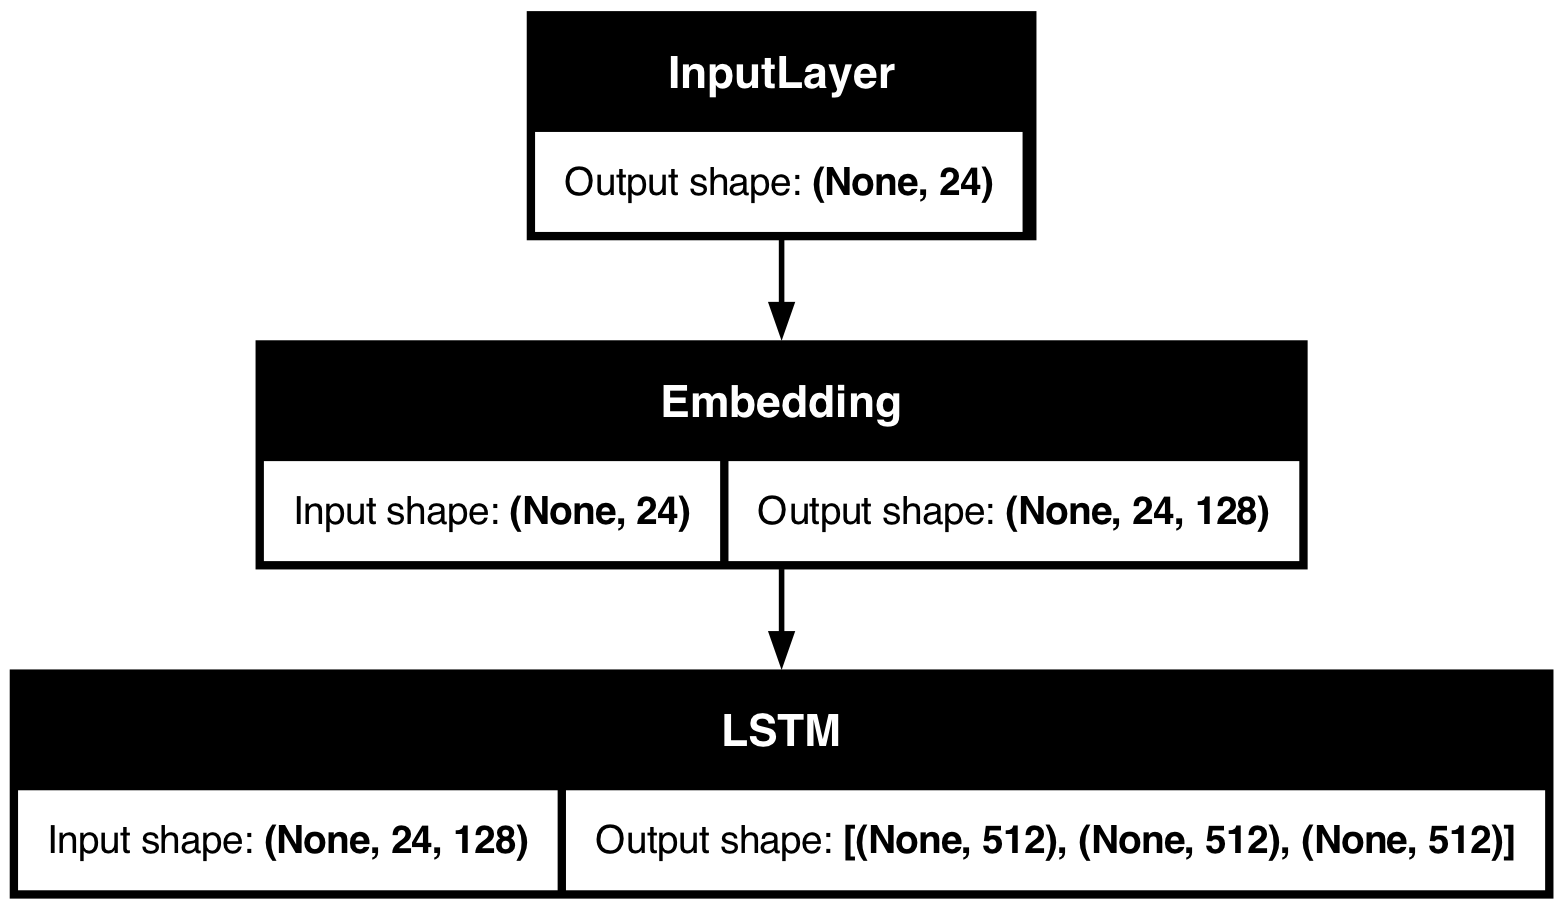

In [19]:
import graphviz
import pydot

from tensorflow.keras.utils import plot_model

plot_model(encoder_model, show_shapes = True)

### 3.2 디코더 생성(teacher-forcing 모델 생성)

In [ ]:

# 1) 디코더 입력
decoder_inputs = layers.Input(shape=(a_inputs_padded.shape[1],))

de_embedding_layer = layers.Embedding(VOCAB_SIZE, EMBED_DIM)
de_x = de_embedding_layer(decoder_inputs)

decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x,h,c = decoder_lstm(de_x, initial_state=encoder_stats)
decoder_dense = layers.Dense(VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(x)


#########################################################


decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs = decoder_outputs
)

decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 128)   │  1,152,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 40, 128)   │  1,152,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,312,768 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 40, 512), │  1,312,768 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 9000)  │  4,617,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,546,536 (36.42 MB)

 Trainable params: 9,546,536 (36.42 MB)

 Non-trainable params: 0 (0.00 B)

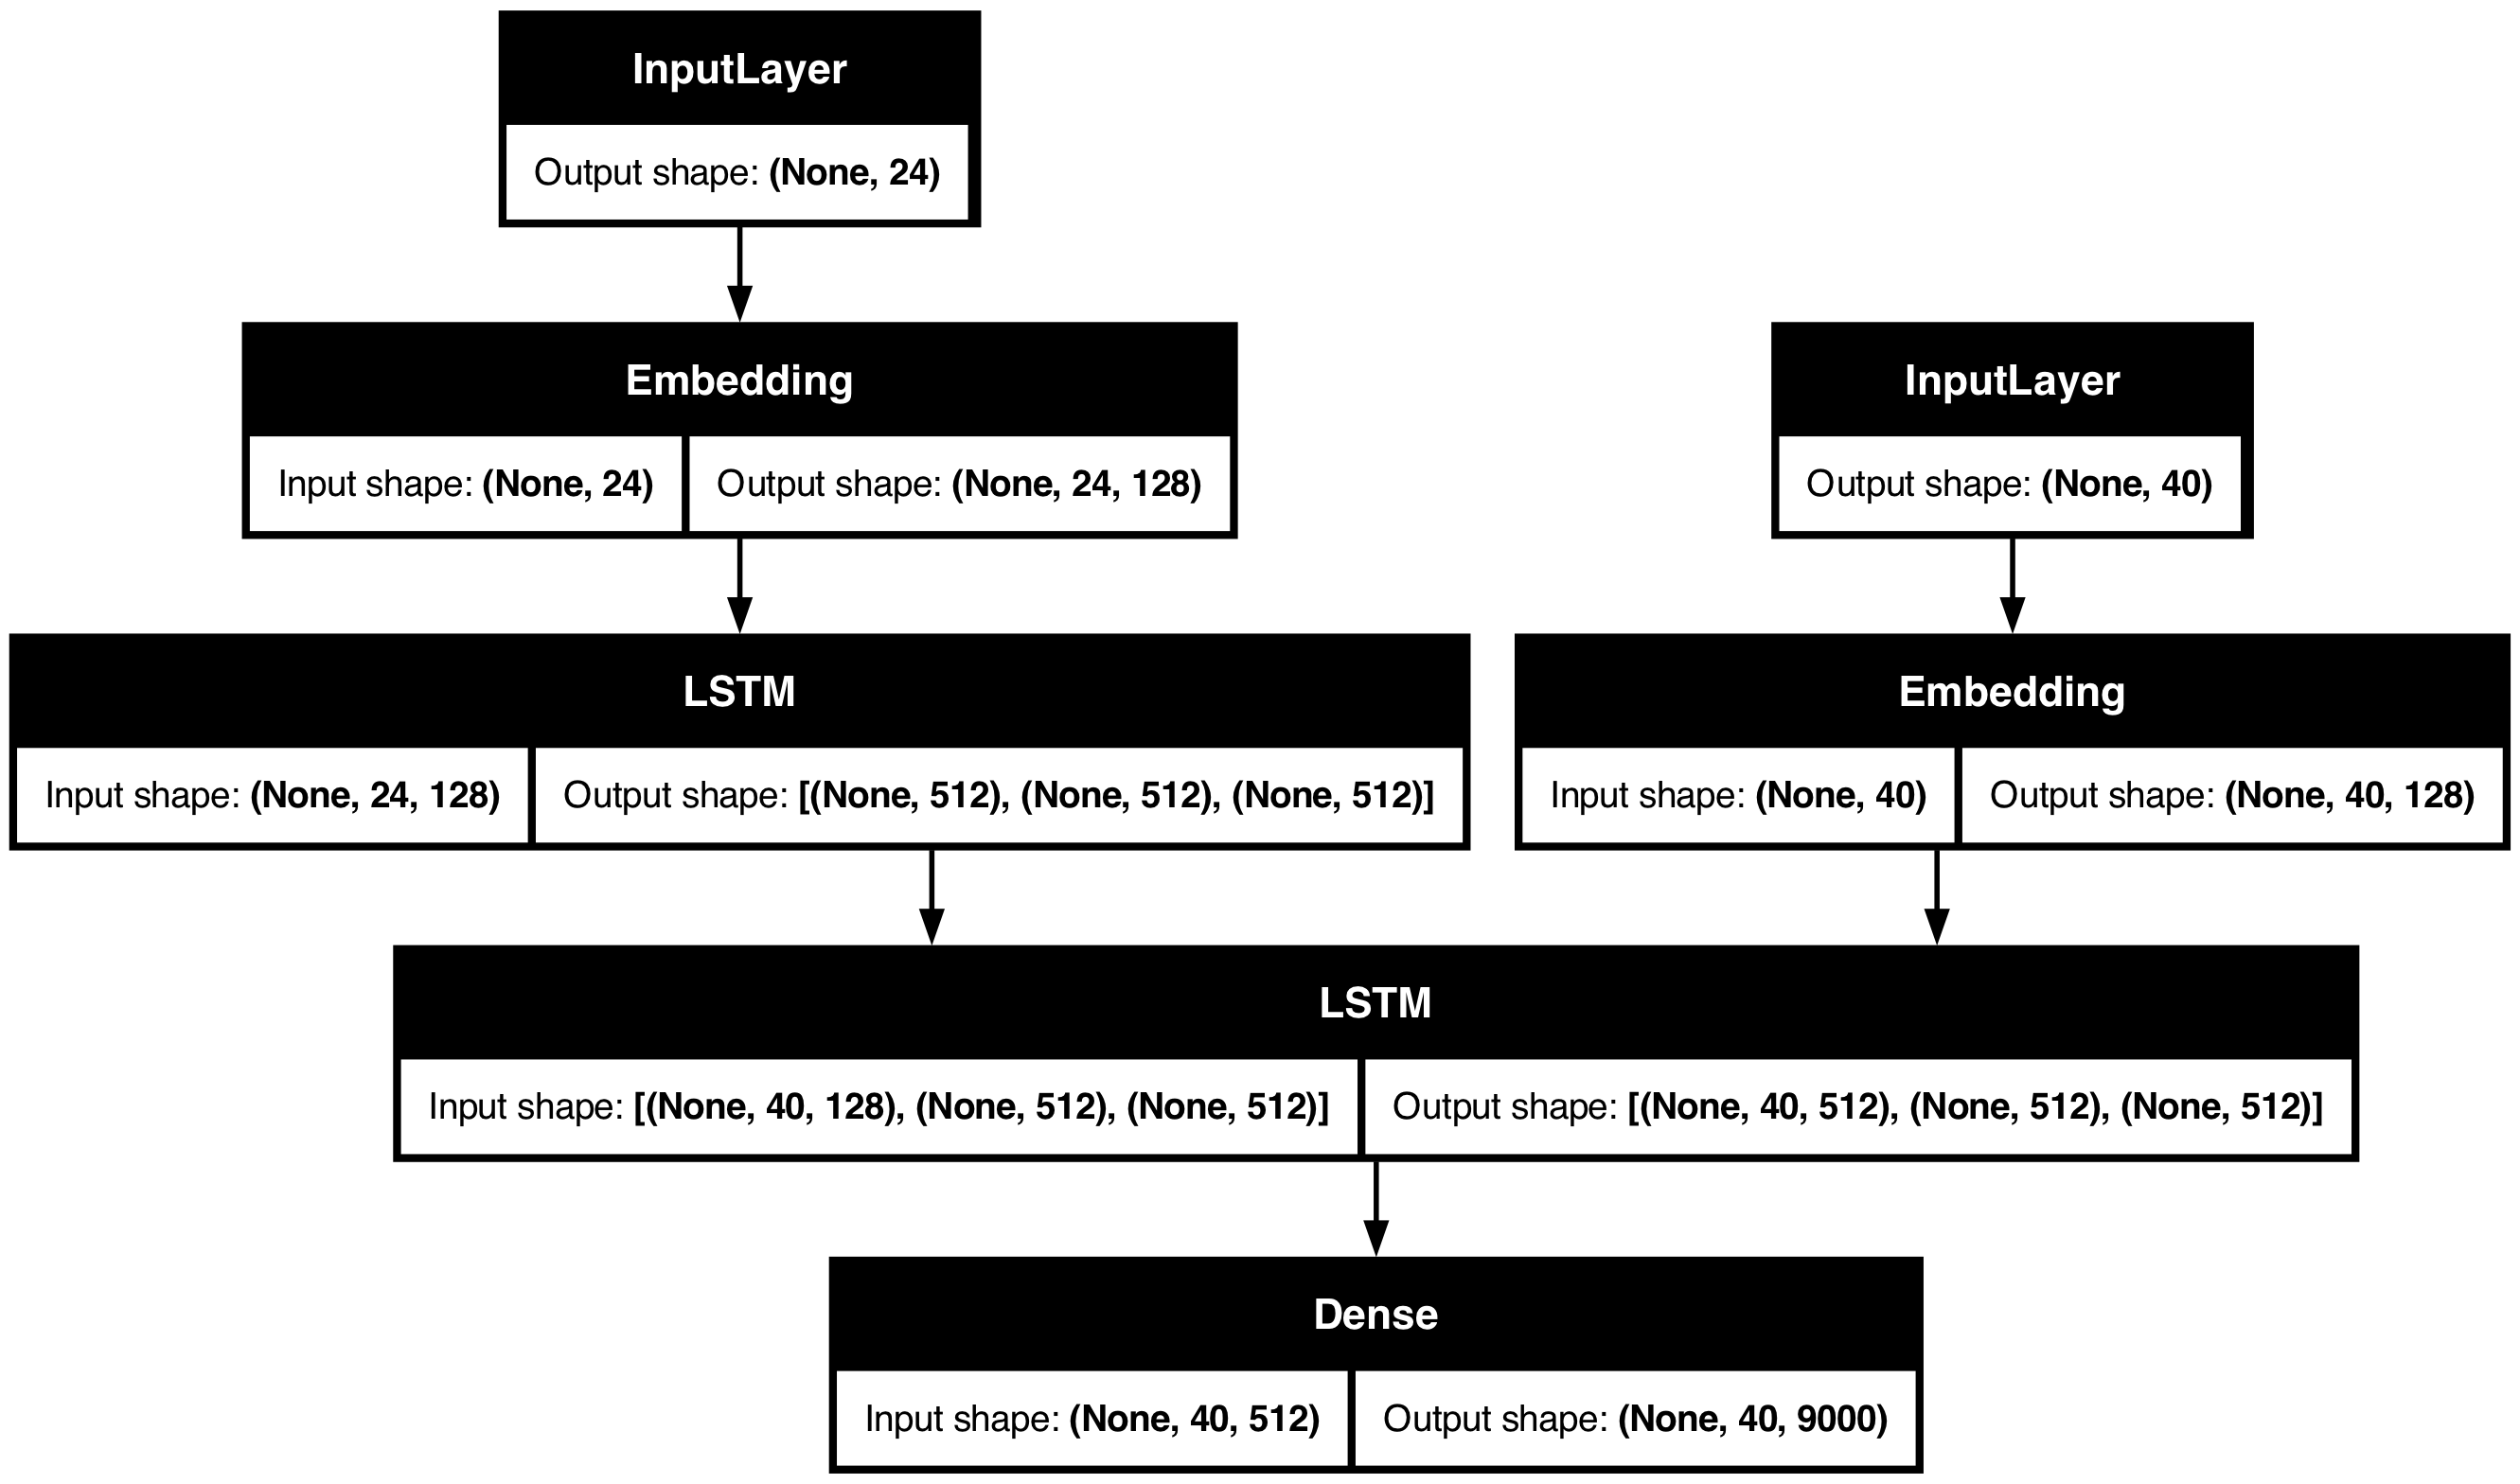

In [21]:
import graphviz
import pydot

from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes = True)

### 3.3 학습 

In [23]:
'''
decoder_teacher_forcing_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [q_inputs_padded, a_inputs_padded],a_targets_padded,
    batch_size=64,
    epochs=70,
    validation_split=0.2

)
'''

"\ndecoder_teacher_forcing_model.compile(\n    loss = 'sparse_categorical_crossentropy',\n    optimizer = 'adam',\n    metrics = ['accuracy']\n)\n\nhistory = decoder_teacher_forcing_model.fit(\n    [q_inputs_padded, a_inputs_padded],a_targets_padded,\n    batch_size=64,\n    epochs=70,\n    validation_split=0.2\n\n)\n"

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 설정
early_stop = EarlyStopping(
    monitor='val_loss',    # 모니터할 값 (val_loss or val_accuracy)
    patience=5,            # 개선 없을 때 몇 epoch 기다릴지
    restore_best_weights=True # 가장 좋은 가중치로 복원
)

decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [q_inputs_padded, a_inputs_padded], a_targets_padded,
    batch_size=64,
    epochs=70,
    validation_split=0.2,
    callbacks=[early_stop]  
)

Epoch 1/70


2025-08-26 17:53:51.409156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


148/148 ━━━━━━━━━━━━━━━━━━━━ 62s 396ms/step - accuracy: 0.7357 - loss: 1.7862 - val_accuracy: 0.7297 - val_loss: 1.6104
Epoch 2/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 64s 431ms/step - accuracy: 0.7781 - loss: 1.2672 - val_accuracy: 0.7525 - val_loss: 1.5427
Epoch 3/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 84s 570ms/step - accuracy: 0.7994 - loss: 1.1940 - val_accuracy: 0.7703 - val_loss: 1.5076
Epoch 4/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 68s 461ms/step - accuracy: 0.8064 - loss: 1.1592 - val_accuracy: 0.7743 - val_loss: 1.4893
Epoch 5/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 65s 431ms/step - accuracy: 0.8112 - loss: 1.1382 - val_accuracy: 0.7759 - val_loss: 1.5097
Epoch 6/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 104s 701ms/step - accuracy: 0.8158 - loss: 1.1202 - val_accuracy: 0.7771 - val_loss: 1.5005
Epoch 7/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 72s 471ms/step - accuracy: 0.8204 - loss: 1.1038 - val_accuracy: 0.7781 - val_loss: 1.5197
Epoch 8/70
148/148 ━━━━━━━━━━━━━━━━━━━━ 64s 429ms/step - accuracy: 0.8234 - loss: 1.0902 - va

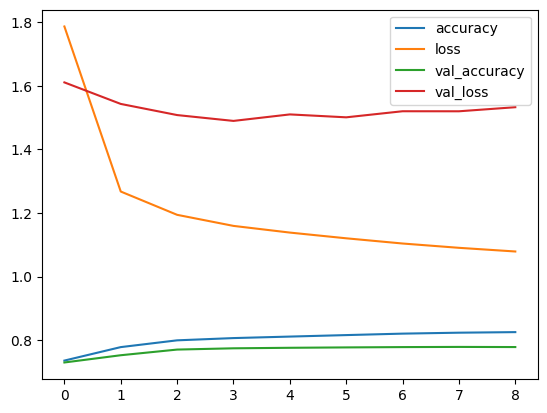

In [23]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

# 4. 모델 추론

### 4.1 디코더(추론 모델) 생성

In [52]:
# ---- (수정) 디코더(추론 모델) 생성 ----
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,), name="dec_h_in")
decoder_cell_state  = layers.Input(shape=(LATENT_DIM,), name="dec_c_in")
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

# ★ 단일 토큰 입력은 정수 dtype 필수
decoder_single_input = layers.Input(shape=(1,), dtype="int32", name="dec_tok_in")

# 학습 때 만든 레이어 재사용 (이미 변수로 가지고 있음)
x = de_embedding_layer(decoder_single_input)                          # (B,1,EMBED_DIM)
x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)        # (B,1,LATENT_DIM)
decoder_states  = [h, c]
decoder_outputs = decoder_dense(x)                                    # (B,1,VOCAB_SIZE)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_tok_in          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 128)    │  1,152,000 │ dec_tok_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_h_in            │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_c_in            │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,312,768 │ embedding_1[2][0… │
│                     │ (None, 512),      │            │ dec_h_in[0][0],   │
│                     │ (None, 512)]      │            │ dec_c_in[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 9000)   │  4,617,000 │ lstm_1[2][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,081,768 (27.01 MB)

 Trainable params: 7,081,768 (27.01 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 추론 함수

In [61]:
# ---- (수정) 추론 함수 ----
def translate(input_seq):
    # input_seq: (1, q_max_len) or (q_max_len,)
    if input_seq.ndim == 1:
        enc_in = input_seq[None, :]
    else:
        enc_in = input_seq

    # 1) 인코더 상태
    encoder_states_value = encoder_model.predict(enc_in, verbose=0)
    decoder_states_value = encoder_states_value  # [h, c]

    # 2) 시작/종료 토큰 (리스트→정수)
    bos_index = int(sp.encode_as_ids("<bos>")[0])
    eos_index = int(sp.encode_as_ids("<eos>")[0])

    # 3) 디코더 시작 입력
    target_seq = np.zeros((1, 1), dtype=np.int32)
    target_seq[0, 0] = bos_index

    # ★ 조각(piece)을 모아서 마지막에 decode_pieces
    output_ids = [] 

    # 4) 디코딩 루프
    max_len = int(a_inputs_padded.shape[1])
    for _ in range(max_len):
        output_tokens, h, c = decoder_inference_model.predict(
            [target_seq] + decoder_states_value, verbose=0
        )

        pred_index = int(np.argmax(output_tokens[0, 0, :]))
        #pred_index = np.random.choice(len(pred_proba), p=pred_proba)

        if pred_index == eos_index:
            break

        if pred_index > 0:  # PAD=0 스킵
            output_ids.append(pred_index)

        target_seq[0, 0] = pred_index
        decoder_states_value = [h, c]

    # ★ 조각들을 자연스럽게 문장으로 복원
    return sp.decode_pieces(output_ids)

### 4.3 테스트

In [62]:
print(q_inputs[:1])

input_seq = q_inputs_padded[:1]
print("A(pred):", translate(input_seq))

['12시 땡!']
A(pred): 잘은..>eoooooooooooooooooooooooooooooooooo


In [55]:
def encode_question_ids(text, max_len=q_max_len):
    ids = sp.encode_as_ids(text)
    if len(ids) < max_len:
        ids = [0] * (max_len - len(ids)) + ids  # pre-padding (PAD=0)
    else:
        ids = ids[-max_len:]
    return np.array(ids, dtype=np.int32)[None, :]  # (1, max_len)

def ask_once(text):
    enc = encode_question_ids(text)
    pred = translate(enc)
    print(f"Q: {text}")
    print(f"A: {pred}")
    return pred


In [56]:
print(q_inputs[:1])

input_seq = q_inputs_padded[:1]   # (1, q_max_len)
print("A(pred):", translate(input_seq))

probe = [
    "안녕?",
    "이름이 뭐야?",
    "지금 몇 시야?",
    "오늘 날씨 어때?",
    "너는 무엇을 할 수 있어?"
]

for q in probe:
    ask_once(q)
    print("-" * 40)

ask_once("안녕?")

['12시 땡!']
A(pred): 잘은..>eoooooooooooooooooooooooooooooooooo
Q: 안녕?
A: 잘은..>eoooooooooooooooooooooooooooooooooo
----------------------------------------
Q: 이름이 뭐야?
A: 잘은..>eoooooooooooooooooooooooooooooooooo
----------------------------------------
Q: 지금 몇 시야?
A: 잘은..>eoooooooooooooooooooooooooooooooooo
----------------------------------------
Q: 오늘 날씨 어때?
A: 잘은..>eoooooooooooooooooooooooooooooooooo
----------------------------------------
Q: 너는 무엇을 할 수 있어?
A: 잘은.>.>oooooooooooooooooooooooooooooooooo
----------------------------------------
Q: 안녕?
A: 잘은..>eoooooooooooooooooooooooooooooooooo


'잘은..>eoooooooooooooooooooooooooooooooooo'

# 5. 간단한 Chatbot 구현

1. 사용자의 입력을 받아 (처리)
2. 추론 함수에 전달해서
3. 응답을 출력
4. 1~3 과정을 종료 전까지 반복

In [25]:



'''
import tensorflow as tf

print("TensorFlow 버전:", tf.__version__)
print("사용 가능한 장치:", tf.config.list_physical_devices())

if tf.config.list_physical_devices("GPU"):
    print("✅ GPU(MPS) 사용 가능")
else:
    print("❌ GPU(MPS) 사용 불가, CPU만 사용")
    
'''

'\nimport tensorflow as tf\n\nprint("TensorFlow 버전:", tf.__version__)\nprint("사용 가능한 장치:", tf.config.list_physical_devices())\n\nif tf.config.list_physical_devices("GPU"):\n    print("✅ GPU(MPS) 사용 가능")\nelse:\n    print("❌ GPU(MPS) 사용 불가, CPU만 사용")\n\n'